# Skapa 2 modeller per ticker   
1. En modell som använder tomorrows close som target  
2. En modell som använder after tomorrows close som target   

In [26]:
import sklearn
import xgboost as xgb
from pytrends.request import TrendReq
import pytrends
import pandas as pd
from datetime import datetime as dt
import yfinance as yf
import ta
import matplotlib.pyplot as plt 
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score    
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
plt.style.use('fivethirtyeight')
pd.set_option('display.width', 200)
import streamlit as st
import google

In [29]:
# print pandas version
print('pandas=={}'.format(pd.__version__))
# print matplotlib version
print('matplotlib=={}'.format(plt.matplotlib.__version__))
# print yfinance version
print('yfinance=={}'.format(yf.__version__))
# print pytreands version
print('pytrends==4.8.0') 
# print python-dateutil version
print('python-dateutil==2.8.2')
# print ta version
print('ta==0.10.2')
# print streamlit version
print('streamlit=={}'.format(st.__version__))
print('xgboost=={}'.format(xgb.__version__))
print('sklearn=={}'.format(sklearn.__version__))
#print google version
print('google-crc32==1.1.2')
# print pandas-ta version
print('pandas-ta==0.3.14b0')


pandas==1.4.3
matplotlib==3.5.2
yfinance==0.1.72
pytrends==4.8.0
python-dateutil==1.4.3
ta==0.10.2
streamlit==1.13.0
xgboost==1.6.1
sklearn==1.1.1
google-crc32==1.1.2
pandas-ta==0.3.14b0


In [3]:
tickers = ['BTC-USD','ETH-USD','BCH-USD','ZRX-USD','XRP-USD']
ticker_names = ['Bitcoin','Ethereum','Bitcoin Cash','0X','Ripple']

In [4]:
# fill up a dataframe with all dates from 2015 up to today
def get_all_dates():
    start_date = dt(2005, 1, 1)
    end_date = dt.today()
    dates = pd.date_range(start_date, end_date)
    df = pd.DataFrame(index=dates)
    return df


## get Google Trends Bitcoin data


Bitcoin
Ethereum
Bitcoin Cash
0X
Ripple


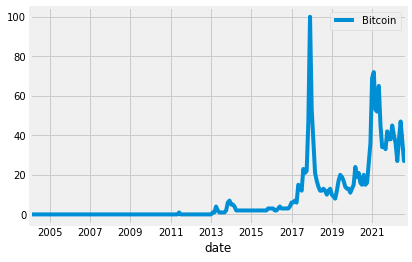

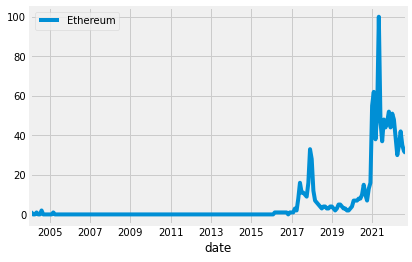

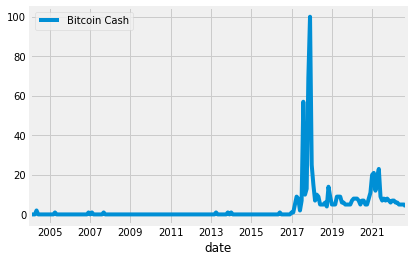

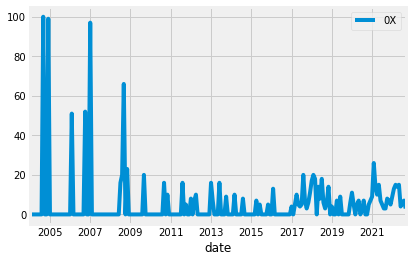

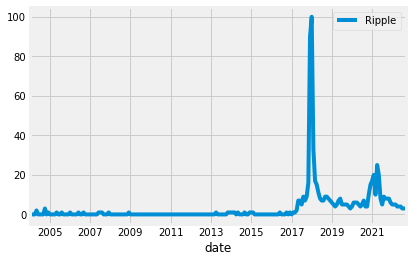

In [5]:
# get google trends data
from pytrends.request import TrendReq

pytrends = TrendReq()
df_trend = get_all_dates()
for ticker_name in ticker_names:
    print(ticker_name)
    pytrends.build_payload(kw_list=[ticker_name], cat=7, timeframe='all')
    df_temp = pytrends.interest_over_time()
    df_temp = df_temp.drop(columns=['isPartial'])
    df_temp.plot()
    df_trend = df_trend.merge(df_temp, how='left', left_index=True, right_index=True)
    df_trend[ticker_name] = df_trend[ticker_name].fillna(method='ffill')/30
    df_trend[ticker_name+'_30'] = df_trend[ticker_name].rolling(30, 1).mean()
    df_trend[ticker_name+'_90'] = df_trend[ticker_name].rolling(90, 1).mean()
    df_trend[ticker_name+'_250'] = df_trend[ticker_name].rolling(250, 1).mean()
    
df_trend = df_trend[ticker_names + [ticker_name+'_30' for ticker_name in ticker_names] + [ticker_name+'_90' for ticker_name in ticker_names] + [ticker_name+'_250' for ticker_name in ticker_names]]


In [6]:
df_trend.to_csv('google_trends.csv')
df_trend.tail()


,Bitcoin,Ethereum,Bitcoin Cash,0X,Ripple,Bitcoin_30,Ethereum_30,Bitcoin Cash_30,0X_30,Ripple_30,Bitcoin_90,Ethereum_90,Bitcoin Cash_90,0X_90,Ripple_90,Bitcoin_250,Ethereum_250,Bitcoin Cash_250,0X_250,Ripple_250
2022-09-29,0.933333,1.033333,0.133333,0.1,0.1,0.932222,1.034444,0.134444,0.104444,0.1,1.021852,1.089259,0.155926,0.179259,0.1,1.178000,1.231067,0.1808,0.320667,0.130267
2022-09-30,0.933333,1.033333,0.133333,0.1,0.1,0.933333,1.033333,0.133333,0.100000,0.1,1.018519,1.087778,0.155556,0.178148,0.1,1.175733,1.228400,0.1804,0.319867,0.130000
2022-10-01,0.933333,1.033333,0.133333,0.1,0.1,0.933333,1.033333,0.133333,0.100000,0.1,1.015185,1.086296,0.155185,0.177037,0.1,1.173467,1.225733,0.1800,0.319067,0.129733
2022-10-02,0.933333,1.033333,0.133333,0.1,0.1,0.933333,1.033333,0.133333,0.100000,0.1,1.011852,1.084815,0.154815,0.175926,0.1,1.171200,1.223067,0.1796,0.318267,0.129467
2022-10-03,0.933333,1.033333,0.133333,0.1,0.1,0.933333,1.033333,0.133333,0.100000,0.1,1.008519,1.083333,0.154444,0.174815,0.1,1.168933,1.220400,0.1792,0.317467,0.129200


## skapa alla modellerna

In [7]:
df_trend.query('index>"2017-01-01"').head(35)

,Bitcoin,Ethereum,Bitcoin Cash,0X,Ripple,Bitcoin_30,Ethereum_30,Bitcoin Cash_30,0X_30,Ripple_30,Bitcoin_90,Ethereum_90,Bitcoin Cash_90,0X_90,Ripple_90,Bitcoin_250,Ethereum_250,Bitcoin Cash_250,0X_250,Ripple_250
2017-01-02,0.2,0.033333,0.033333,0.133333,0.000000,0.137778,0.033333,0.002222,0.008889,0.031111,0.113704,0.022222,0.000741,0.002963,0.021481,0.108533,0.029333,0.004267,0.001067,0.012267
2017-01-03,0.2,0.033333,0.033333,0.133333,0.000000,0.140000,0.033333,0.003333,0.013333,0.030000,0.114815,0.022222,0.001111,0.004444,0.021111,0.109067,0.029333,0.004400,0.001600,0.012267
2017-01-04,0.2,0.033333,0.033333,0.133333,0.000000,0.142222,0.033333,0.004444,0.017778,0.028889,0.115926,0.022222,0.001481,0.005926,0.020741,0.109600,0.029333,0.004533,0.002133,0.012267
2017-01-05,0.2,0.033333,0.033333,0.133333,0.000000,0.144444,0.033333,0.005556,0.022222,0.027778,0.117037,0.022222,0.001852,0.007407,0.020370,0.110133,0.029333,0.004667,0.002667,0.012267
2017-01-06,0.2,0.033333,0.033333,0.133333,0.000000,0.146667,0.033333,0.006667,0.026667,0.026667,0.118148,0.022222,0.002222,0.008889,0.020000,0.110533,0.029333,0.004800,0.003200,0.012267
2017-01-07,0.2,0.033333,0.033333,0.133333,0.000000,0.148889,0.033333,0.007778,0.031111,0.025556,0.119259,0.022222,0.002593,0.010370,0.019630,0.110933,0.029333,0.004933,0.003733,0.012267
2017-01-08,0.2,0.033333,0.033333,0.133333,0.000000,0.151111,0.033333,0.008889,0.035556,0.024444,0.120370,0.022222,0.002963,0.011852,0.019259,0.111333,0.029333,0.005067,0.004267,0.012267
2017-01-09,0.2,0.033333,0.033333,0.133333,0.000000,0.153333,0.033333,0.010000,0.040000,0.023333,0.121481,0.022222,0.003333,0.013333,0.018889,0.111733,0.029333,0.005200,0.004800,0.012267
2017-01-10,0.2,0.033333,0.033333,0.133333,0.000000,0.155556,0.033333,0.011111,0.044444,0.022222,0.122593,0.022222,0.003704,0.014815,0.018519,0.112133,0.029333,0.005333,0.005333,0.012267
2017-01-11,0.2,0.033333,0.033333,0.133333,0.000000,0.157778,0.033333,0.012222,0.048889,0.021111,0.123704,0.022222,0.004074,0.016296,0.018148,0.112533,0.029333,0.005467,0.005867,0.012267


In [8]:
def get_all(tickers):
    df = pd.DataFrame()
    for ticker in tickers:
        all_tickers = yf.download(ticker)
        df[ticker] = yf.download(ticker, period='max')['Close']
        
    df.index = pd.to_datetime(df.index)
    return df

In [9]:
df_org= get_all(tickers)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [10]:
display(df_org.isna().sum())
df_org.shape

BTC-USD       0
ETH-USD    1149
BCH-USD    1149
ZRX-USD    1081
XRP-USD    1149
dtype: int64

(2939, 5)

In [11]:

def fit_predict(train, test, target, predictors, model, proba_val=None):
    model.fit(train[predictors], train[target])

    if proba_val:  # använd proba
        preds = model.predict_proba(test[predictors])[:, 1]
        preds[preds >= proba_val] = 1
        preds[preds < proba_val] = 0
    else:    # använd predict utan proba
        preds = model.predict(test[predictors])

    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test[target], preds], axis=1)

    return combined



In [12]:
def backtest(data, target, model, predictors, proba_val=0.6, start=360, step=180):
    """"
    Args:
        data (DataFrame): Data to use for backtesting
        model: Tex RandomForestClassifier
        predictors: Features in data to use for backtesting
        proba_val (float): threshold för att få 1 annars 0 i predictions.
        start (int, optional): Hur många rader in i data skall vi starta testet. Defaults to 180.
        step (int, optional): Hur många rader skall vi ta i varje batch framåt. Defaults to 60.

    Returns:
        DataFrame: Två kolumner med true_y och prediktioner 
    """
    all_predictions = []
    print('last date', data.iloc[-1].name)
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = fit_predict(train, test, target, predictors, model, proba_val=proba_val)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)


def print_results(predictions, target):
    prec = precision_score(predictions[target], predictions["Predictions"])
    print(f'Fördelning av {target}: 1 vs 0:')
    print(predictions[target].value_counts() / predictions.shape[0])

    predictions.Predictions = predictions.Predictions.astype(int)
    print(predictions.value_counts())
    print(f"Precision:\t{prec:.4f}")
    return prec


### Beräkna predictors

In [13]:
def new_features(df_, ticker, target):
    df = df_.copy()
    # tidsintervall i dagar för rullande medelvärden
    # skulle helst ha med upp till 4 år men ETH har för få värden
    horizons = [2, 5, 60, 250]
    new_predictors = []
    df['stoch_k'] = ta.momentum.stochrsi_k(df[ticker], window=10)

    # Target
    # tomorrow's close price - alltså nästa dag
    df['Tomorrow'] = df[ticker].shift(-1)
    # after tomorrow's close price - alltså om två dagar
    df['After_tomorrow'] = df[ticker].shift(-2)
    df['y1'] = (df['Tomorrow'] > df[ticker]).astype(int)
    df['y2'] = (df['After_tomorrow'] > df[ticker]).astype(int)
    # df.dropna(inplace=True)

    for horizon in horizons:
        rolling_averages = df.rolling(horizon, 1).mean()

        ratio_column = f"Close_Ratio_{horizon}"
        df[ratio_column] = df[ticker] / rolling_averages[ticker]

        trend_column = f"Trend_{horizon}"
        df[trend_column] = df.shift(1).rolling(horizon, 1).sum()[target]

        new_predictors += [ratio_column, trend_column]

    new_predictors.append('stoch_k')
    # df = df.dropna()
    return df, new_predictors


In [14]:
pd.options.display.max_columns = 200    # default 20
pd.options.display.max_colwidth = 60  # default 50
pd.options.display.precision = 4      # default 6
print(tickers[0])
df, new_predictors = new_features(df_org, tickers[0], 'y1')
df[new_predictors+['y1']]


BTC-USD


,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,stoch_k,y1
Date,,,,,,,,,,
2014-09-17,1.0000,NaN,1.0000,NaN,1.0000,NaN,1.0000,NaN,NaN,0
2014-09-18,0.9627,0.0,0.9627,0.0,0.9627,0.0,0.9627,0.0,NaN,0
2014-09-19,0.9638,0.0,0.9278,0.0,0.9278,0.0,0.9278,0.0,NaN,1
2014-09-20,1.0176,1.0,0.9704,1.0,0.9704,1.0,0.9704,1.0,NaN,0
2014-09-21,0.9875,1.0,0.9567,1.0,0.9567,1.0,0.9567,1.0,NaN,1
...,...,...,...,...,...,...,...,...,...,...
2022-09-29,1.0038,2.0,1.0180,3.0,0.9261,28.0,0.6378,122.0,0.9633,0
2022-09-30,0.9964,1.0,1.0041,3.0,0.9223,28.0,0.6346,121.0,0.9591,0
2022-10-01,0.9969,0.0,0.9970,2.0,0.9192,28.0,0.6321,120.0,0.8463,0


### Vi använder XGBoost

Loop öve all tickers och skapa 2 modeller  
    En mot y1 och en mot y2  
    spara båda modellerna  
Totalt 2 modeller per ticker (= 10 st)    

Modellens namn:  
    ticker[:3]_y1  
    ticker[:3]_y2

In [15]:
def add_google_trends(df_, df_trend, ticker, new_predictors):
    df = df_.copy()
    
    lookup = {'BTC-USD': 'Bitcoin', 'ETH-USD': 'Ethereum', 'BCH-USD': 'Bitcoin Cash', 'XRP-USD': 'Ripple', 'ZRX-USD': '0X'}
    ticker_namn = lookup[ticker]
    
    df[ticker_namn + '_goog30'] = df_trend[ticker_namn + '_30']
    new_predictors.append(ticker_namn + '_goog30')
    df[ticker_namn + '_goog90'] = df_trend[ticker_namn + '_90']
    new_predictors.append(ticker_namn + '_goog90')
    df[ticker_namn + '_goog250'] = df_trend[ticker_namn + '_250']
    new_predictors.append(ticker_namn + '_goog250')
    
    return df, new_predictors

##### Generate all models and save them #####
xgb_params = {'gamma': 0.7, 'learning_rate': 0.005, 'max_depth': 7,
                  'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.4}
for enum, ticker in enumerate(tickers):
    namn = ticker[:3]
    print(namn)
    target = 'y1'
    model = xgb.XGBClassifier(**xgb_params,  random_state=2022, n_jobs=-1)
    df, new_predictors = new_features(df_org, ticker, target)
    df, new_predictors = add_google_trends(df, df_trend, ticker, new_predictors)
    predictions_xgb = backtest(df, target, model, new_predictors, proba_val= 0.55, step=30)
    xgb_try = print_results(predictions_xgb, target)
    display(pd.DataFrame(model.feature_importances_,columns=['importance'], index=new_predictors).sort_values(by='importance', ascending=False))
    
    test_index = int(df.shape[0] * 0.8)
    train = df.iloc[:test_index].copy()
    test = df.iloc[test_index:].copy()
    model = xgb.XGBClassifier(early_stopping_rounds=100, 
                        **xgb_params,  
                        random_state=2022, n_jobs=-1)
    model.fit(train[new_predictors], train[target],
            eval_set=[(train[new_predictors], train[target]),
                      (test[new_predictors], test[target])],
            verbose=False)
    
    # pickle.dump(xgb, open(f'{namn}_y1.pkl', 'wb'))
    model.save_model(f'{namn}_{target}.json')
    
    
    target='y2'
    model = xgb.XGBClassifier(**xgb_params,  random_state=2022, n_jobs=-1)
    df, new_predictors = new_features(df_org, ticker, target)
    df, new_predictors = add_google_trends(df, df_trend, ticker, new_predictors)
    predictions_xgb = backtest(df, target, model, new_predictors, proba_val=0.55, step=30)
    xgb_try = print_results(predictions_xgb, target)
    display(pd.DataFrame(model.feature_importances_,columns=['importance'], index=new_predictors).sort_values(by='importance', ascending=False))

    test_index = int(df.shape[0] * 0.8)
    train = df.iloc[:test_index].copy()
    test = df.iloc[test_index:].copy()
    model = xgb.XGBClassifier(early_stopping_rounds=100, 
                        **xgb_params,  
                        random_state=2022, n_jobs=-1)
    model.fit(train[new_predictors], train[target],
            eval_set=[(train[new_predictors], train[target]),
                      (test[new_predictors], test[target])],
            verbose=False)

    # pickle dump model
    # pickle.dump(xgb, open(f'{namn}_y2.pkl', 'wb'))
    model.save_model(f'{namn}_{target}.json')

    

BTC
last date 2022-10-03 00:00:00
Fördelning av y1: 1 vs 0:
1    0.5421
0    0.4579
Name: y1, dtype: float64
y1  Predictions
1   0              935
0   0              805
1   1              463
0   1              376
dtype: int64
Precision:	0.5518


,importance
Bitcoin_goog250,0.0876
Trend_5,0.0875
Trend_60,0.0849
Close_Ratio_250,0.0846
Bitcoin_goog90,0.0843
Close_Ratio_2,0.0840
Close_Ratio_60,0.0833
Trend_250,0.0826
stoch_k,0.0824
Close_Ratio_5,0.0819


last date 2022-10-03 00:00:00
Fördelning av y2: 1 vs 0:
1    0.5537
0    0.4463
Name: y2, dtype: float64
y2  Predictions
1   1              767
0   0              753
1   0              661
0   1              398
dtype: int64
Precision:	0.6584


,importance
Trend_2,0.2273
Close_Ratio_5,0.0916
Close_Ratio_2,0.0905
Trend_5,0.0740
Trend_60,0.0696
Bitcoin_goog250,0.0675
Close_Ratio_60,0.0663
stoch_k,0.0663
Bitcoin_goog90,0.0637
Trend_250,0.0615


ETH
last date 2022-10-03 00:00:00
Fördelning av y1: 1 vs 0:
0    0.6433
1    0.3567
Name: y1, dtype: float64
y1  Predictions
0   0              1450
1   0               675
    1               245
0   1               209
dtype: int64
Precision:	0.5396


,importance
Close_Ratio_60,0.2140
Close_Ratio_250,0.1634
Close_Ratio_5,0.1494
Trend_60,0.1014
Close_Ratio_2,0.0881
stoch_k,0.0451
Ethereum_goog30,0.0421
Trend_250,0.0400
Ethereum_goog250,0.0396
Trend_2,0.0396


last date 2022-10-03 00:00:00
Fördelning av y2: 1 vs 0:
0    0.6433
1    0.3567
Name: y2, dtype: float64
y2  Predictions
0   0              1464
1   0               591
    1               329
0   1               195
dtype: int64
Precision:	0.6279


,importance
Close_Ratio_250,0.2273
Close_Ratio_5,0.1308
Close_Ratio_60,0.1274
Trend_5,0.1025
Close_Ratio_2,0.0963
Trend_2,0.0953
Trend_60,0.0507
Ethereum_goog250,0.0352
Ethereum_goog30,0.0346
Trend_250,0.0336


BCH
last date 2022-10-03 00:00:00
Fördelning av y1: 1 vs 0:
0    0.6642
1    0.3358
Name: y1, dtype: float64
y1  Predictions
0   0              1606
1   0               744
    1               122
0   1               107
dtype: int64
Precision:	0.5328


,importance
Close_Ratio_60,0.2525
Close_Ratio_250,0.1549
Close_Ratio_5,0.0911
Trend_60,0.0850
Close_Ratio_2,0.0838
stoch_k,0.0619
Trend_5,0.0526
Trend_250,0.0472
Bitcoin Cash_goog90,0.0435
Bitcoin Cash_goog30,0.0435


last date 2022-10-03 00:00:00
Fördelning av y2: 1 vs 0:
0    0.67
1    0.33
Name: y2, dtype: float64
y2  Predictions
0   0              1588
1   0               593
    1               258
0   1               140
dtype: int64
Precision:	0.6482


,importance
Close_Ratio_60,0.2340
Close_Ratio_250,0.2009
Trend_2,0.1037
Close_Ratio_5,0.0978
Close_Ratio_2,0.0797
stoch_k,0.0498
Trend_60,0.0494
Bitcoin Cash_goog250,0.0381
Trend_250,0.0379
Bitcoin Cash_goog30,0.0379


ZRX
last date 2022-10-03 00:00:00
Fördelning av y1: 1 vs 0:
0    0.6475
1    0.3525
Name: y1, dtype: float64
y1  Predictions
0   0              1550
1   0               790
0   1               120
1   1               119
dtype: int64
Precision:	0.4979


,importance
Close_Ratio_250,0.2007
Close_Ratio_2,0.1605
Close_Ratio_5,0.1519
Close_Ratio_60,0.1272
Trend_60,0.0565
Trend_250,0.0491
stoch_k,0.0440
Trend_2,0.0437
Trend_5,0.0422
0X_goog250,0.0415


last date 2022-10-03 00:00:00
Fördelning av y2: 1 vs 0:
0    0.6549
1    0.3451
Name: y2, dtype: float64
y2  Predictions
0   0              1523
1   0               678
    1               212
0   1               166
dtype: int64
Precision:	0.5608


,importance
Close_Ratio_250,0.1860
Close_Ratio_5,0.1820
Close_Ratio_2,0.1081
Close_Ratio_60,0.1026
Trend_2,0.1022
Trend_5,0.0567
Trend_60,0.0519
stoch_k,0.0432
Trend_250,0.0428
0X_goog30,0.0422


XRP
last date 2022-10-03 00:00:00
Fördelning av y1: 1 vs 0:
0    0.6599
1    0.3401
Name: y1, dtype: float64
y1  Predictions
0   0              1594
1   0               735
    1               142
0   1               108
dtype: int64
Precision:	0.5680


,importance
Close_Ratio_250,0.2321
Close_Ratio_2,0.1599
Trend_60,0.1332
Close_Ratio_5,0.1159
Close_Ratio_60,0.0781
stoch_k,0.0458
Ripple_goog250,0.0420
Ripple_goog90,0.0408
Trend_250,0.0382
Ripple_goog30,0.0381


last date 2022-10-03 00:00:00
Fördelning av y2: 1 vs 0:
0    0.672
1    0.328
Name: y2, dtype: float64
y2  Predictions
0   0              1618
1   0               678
    1               168
0   1               115
dtype: int64
Precision:	0.5936


,importance
Close_Ratio_250,0.2585
Close_Ratio_2,0.1218
Trend_2,0.0997
Close_Ratio_5,0.0976
Trend_60,0.0875
Close_Ratio_60,0.0682
stoch_k,0.0629
Trend_5,0.0495
Ripple_goog90,0.0412
Ripple_goog250,0.0385


In [16]:
ticker='BTC-USD'
namn = ticker[:3]
print(namn)

# display(df_org)
df, new_predictors = new_features(df_org, ticker, 'y1')
df, new_predictors = add_google_trends(df, df_trend, ticker, new_predictors)
# preddar = backtest(df, 'y1', xgb, new_predictors, proba_val=0.55, step=30)
# print_results(preddar, 'y1')
# display(pd.DataFrame(xgb.feature_importances_, columns=[
#     'importance'], index=new_predictors).sort_values(by='importance', ascending=False))


BTC


In [17]:
loaded_model = xgb.XGBClassifier()
ticker='BTC-USD'
name=ticker[:3]
loaded_model.load_model(name+'_y1.json')
loaded_model.best_ntree_limit
# preddar = backtest(df, 'y1', loaded_model, new_predictors, proba_val=0.55, step=30)
# print_results(preddar, 'y1')


12